In [1]:
import json
from pathlib import Path
from typing import List, Optional
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def _load_metrics(models_dir: Path) -> pd.DataFrame:
    """
    Load metrics.json files from ROOT_DIR/models/<cancer>/<modality>/metrics.json.
    Extracts test_cidx, test_roc_auc, and test_avg_precision.
    """
    records: List[dict] = []

    for metrics_file in models_dir.glob("*/*/metrics.json"):
        cancer = metrics_file.parents[1].name
        modality = metrics_file.parent.name

        try:
            with metrics_file.open() as fp:
                metrics = json.load(fp)
        except (json.JSONDecodeError, OSError) as exc:
            print(f"⚠️ Skipping unreadable file {metrics_file}: {exc}")
            continue

        def _float_or_none(key: str) -> Optional[float]:
            val = metrics.get(key)
            try:
                return float(val) if val is not None else None
            except (TypeError, ValueError):
                return None

        test_cidx = _float_or_none("test_cidx")
        test_roc_auc = _float_or_none("test_roc_auc")
        test_avg_precision = _float_or_none("test_avg_precision")

        if test_cidx is None:
            print(f"⚠️ No usable test_cidx in {metrics_file}")
            continue

        records.append(
            dict(
                cancer=cancer,
                modality=modality,
                test_cidx=test_cidx,
                test_roc_auc=test_roc_auc,
                test_avg_precision=test_avg_precision,
                path=str(metrics_file),
            )
        )

    if not records:
        raise RuntimeError("No metrics.json files were successfully read!")

    return pd.DataFrame.from_records(records)

In [3]:
def _save_fig(fig: plt.Figure, plot_dir: Path, name: str) -> Path:
    plot_dir.mkdir(parents=True, exist_ok=True)
    out = plot_dir / f"{name}.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print(f"[saved plot] {out}")
    return out


def _set_style():
    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=0.9)

In [5]:
def plot_by_modality(df: pd.DataFrame, plot_dir: Path) -> Path:
    order = (
        df.groupby("modality")["test_cidx"].median().sort_values(ascending=False).index
    )

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=df, x="modality", y="test_cidx", order=order, ax=ax, linewidth=1)
    ax.set(
        title="Test c-index across modalities (ordered by median)",
        xlabel="Modality",
        ylabel="Test c-index",
    )
    ax.tick_params(axis="x", rotation=45)
    fig.tight_layout()
    return _save_fig(fig, plot_dir, "modality_summary")

In [6]:
def plot_by_cancer(df: pd.DataFrame, plot_dir: Path) -> Path:
    order = (
        df.groupby("cancer")["test_cidx"].median().sort_values(ascending=False).index
    )

    fig, ax = plt.subplots(figsize=(14, 6))
    sns.boxplot(data=df, x="cancer", y="test_cidx", order=order, ax=ax, linewidth=1)

    # Annotate each cancer with its winning modality
    y_offset = 0.01
    for xpos, cancer in enumerate(order):
        subset = df[df["cancer"] == cancer]
        idx = subset["test_cidx"].idxmax()
        best_val = subset.loc[idx, "test_cidx"]
        best_mod = subset.loc[idx, "modality"]
        ax.text(
            xpos,
            best_val + y_offset,
            best_mod,
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

    ax.set(
        title="Test c-index across cancer types (ordered by median)",
        xlabel="Cancer type",
        ylabel="Test c-index",
    )
    ax.tick_params(axis="x", rotation=90)
    fig.tight_layout()
    return _save_fig(fig, plot_dir, "cancer_summary")

In [7]:
def plot_metric_by_modality(df, metric, title, ylabel, name, plot_dir):
    data = df.dropna(subset=[metric])
    if data.empty:
        print(f"⚠️ Skipping {metric}: no data")
        return None

    order = (
        data.groupby("modality")[metric].median().sort_values(ascending=False).index
    )

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=data, x="modality", y=metric, order=order, ax=ax, linewidth=1)
    ax.set(title=title, xlabel="Modality", ylabel=ylabel)
    ax.tick_params(axis="x", rotation=45)
    fig.tight_layout()
    return _save_fig(fig, plot_dir, name)

In [8]:
def plot_metric_by_cancer(df, metric, title, ylabel, name, plot_dir):
    data = df.dropna(subset=[metric])
    if data.empty:
        print(f"⚠️ Skipping {metric}: no data")
        return None

    order = (
        data.groupby("cancer")[metric].median().sort_values(ascending=False).index
    )

    fig, ax = plt.subplots(figsize=(14, 6))
    sns.boxplot(data=data, x="cancer", y=metric, order=order, ax=ax, linewidth=1)
    ax.set(title=title, xlabel="Cancer type", ylabel=ylabel)
    ax.tick_params(axis="x", rotation=90)
    fig.tight_layout()
    return _save_fig(fig, plot_dir, name)

In [9]:
def plot_winner_counts(df: pd.DataFrame, plot_dir: Path) -> Path:
    winners = df.loc[df.groupby("cancer")["test_cidx"].idxmax()]
    counts = winners["modality"].value_counts().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x=counts.index, y=counts.values, ax=ax)
    ax.set(
        title="Modality with highest c-index (count across cancers)",
        xlabel="Modality",
        ylabel="Number of cancers",
    )
    ax.bar_label(ax.containers[0], padding=3)
    ax.tick_params(axis="x", rotation=45)
    fig.tight_layout()
    return _save_fig(fig, plot_dir, "highest_cindex")

In [10]:
def plot_rank_summaries(df: pd.DataFrame, plot_dir: Path):
    outputs = []
    df = df.copy()
    df["rank"] = df.groupby("cancer")["test_cidx"].rank(
        method="min", ascending=False
    )

    # Sum of ranks
    rank_sum = df.groupby("modality")["rank"].sum().sort_values()
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    sns.barplot(x=rank_sum.index, y=rank_sum.values, ax=ax1)
    ax1.set(
        title="Sum of modality ranks (lower = better)",
        xlabel="Modality",
        ylabel="Sum of ranks",
    )
    ax1.bar_label(ax1.containers[0], padding=3)
    ax1.tick_params(axis="x", rotation=45)
    fig1.tight_layout()
    outputs.append(_save_fig(fig1, plot_dir, "summed_ranks"))

    # Distribution of ranks
    median_rank = df.groupby("modality")["rank"].median().sort_values()
    order = median_rank.index

    fig2, ax2 = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=df, x="modality", y="rank", order=order, linewidth=1, ax=ax2)
    ax2.axhline(1, ls="--", c="grey", lw=0.8)
    ax2.set(
        title="Distribution of modality ranks",
        xlabel="Modality",
        ylabel="Rank (lower = better)",
    )
    ax2.tick_params(axis="x", rotation=45)
    fig2.tight_layout()
    outputs.append(_save_fig(fig2, plot_dir, "median_ranks"))

    return outputs

In [ ]:
from itertools import combinations
def _extract_gene_id(event: str) -> Optional[str]:
    """
    Extract the Ensembl gene identifier from an event string.
    The expected format is <event>::ENSG...#<location>, but the parser is robust
    to missing delimiters. When a version suffix is present (e.g., .19) it is
    stripped. Returns None when no gene-like token is found.
    """
    if not isinstance(event, str):
        return None

    remainder = event.split("::", 1)[-1] if "::" in event else event
    gene_token = remainder.split("#", 1)[0]
    gene_id = gene_token.split(".", 1)[0]

    if gene_id.startswith("ENSG") and any(ch.isdigit() for ch in gene_id[4:]):
        return gene_id
    return None


def _load_top_events(shap_file: Path, top_n: int = 100) -> pd.DataFrame:
    """
    Load the top-N most influential events from a shap_mean_abs.csv file.
    The function assumes the first column contains event identifiers and the first
    numeric column contains the SHAP scores used for ranking.
    """
    if top_n <= 0:
        raise ValueError("top_n must be positive")

    df = pd.read_csv(shap_file)
    if df.empty:
        print(f"⚠️ {shap_file} is empty; skipping.")
        return df

    event_col = "feature" if "feature" in df.columns else df.columns[0]
    value_cols = df.select_dtypes(include="number").columns
    if not len(value_cols):
        raise ValueError(f"No numeric columns found in {shap_file}")

    value_col = value_cols[0]
    top_events = df.sort_values(value_col, ascending=False).head(top_n).copy()
    top_events["gene_id"] = top_events[event_col].apply(_extract_gene_id)
    return top_events[[event_col, "gene_id", value_col]]


def _collect_top_gene_sets(shap_root: Path, top_n: int = 100) -> dict:
    """
    Build a mapping of cancer → modality → set of top genes from SHAP outputs.
    """
    if not shap_root.exists():
        print(f"⚠️ SHAP root {shap_root} does not exist.")
        return {}

    gene_sets = {}
    for cancer_dir in sorted(p for p in shap_root.iterdir() if p.is_dir()):
        cancer = cancer_dir.name
        cancer_sets = {}

        for modality_dir in sorted(p for p in cancer_dir.iterdir() if p.is_dir()):
            modality = modality_dir.name
            shap_file = modality_dir / "shap_mean_abs.csv"
            if not shap_file.exists():
                print(f"⚠️ Missing {shap_file}")
                continue

            try:
                top_events = _load_top_events(shap_file, top_n=top_n)
            except Exception as exc:  # pragma: no cover - defensive logging in notebook
                print(f"⚠️ Skipping {shap_file}: {exc}")
                continue

            genes = set(top_events["gene_id"].dropna())
            if not genes:
                print(f"⚠️ No gene IDs parsed for {cancer}/{modality}")
                continue

            cancer_sets[modality] = genes

        if cancer_sets:
            gene_sets[cancer] = cancer_sets

    return gene_sets


def compute_gene_overlaps(gene_sets: dict) -> pd.DataFrame:
    """
    Calculate pairwise overlaps of top genes across modalities for each cancer.
    Returns a DataFrame with overlap counts, union sizes, Jaccard indices, and
    the shared gene lists.
    """
    records = []
    for cancer, modality_sets in gene_sets.items():
        for mod_a, mod_b in combinations(sorted(modality_sets), 2):
            genes_a = modality_sets[mod_a]
            genes_b = modality_sets[mod_b]
            overlap = genes_a & genes_b
            union = genes_a | genes_b

            records.append(
                dict(
                    cancer=cancer,
                    modality_a=mod_a,
                    modality_b=mod_b,
                    overlap_count=len(overlap),
                    union_count=len(union),
                    jaccard=len(overlap) / len(union) if union else None,
                    shared_genes=sorted(overlap),
                )
            )

    return pd.DataFrame.from_records(records)


def summarize_gene_overlaps(overlap_df: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize overlap statistics per cancer type.
    """
    if overlap_df.empty:
        return overlap_df

    summary = (
        overlap_df.groupby("cancer")
        .agg(
            comparisons=("cancer", "size"),
            mean_jaccard=("jaccard", "mean"),
            median_jaccard=("jaccard", "median"),
            max_overlap=("overlap_count", "max"),
        )
        .reset_index()
        .sort_values(by="median_jaccard", ascending=False)
    )
    return summary


In [ ]:
def plot_cancer_overlap_heatmaps(overlap_df: pd.DataFrame, plot_dir: Path):
    """
    Create and save Jaccard overlap heatmaps for each cancer type.
    """
    if overlap_df.empty:
        print("⚠️ Skipping overlap heatmaps: no overlap data available")
        return []

    outputs = []
    plot_dir = plot_dir / "gene_overlap"
    plot_dir.mkdir(parents=True, exist_ok=True)

    for cancer, subset in overlap_df.groupby("cancer"):
        if subset.empty:
            continue

        modalities = sorted(set(subset["modality_a"]) | set(subset["modality_b"]))
        if len(modalities) < 2:
            print(f"⚠️ Skipping {cancer}: not enough modalities for a heatmap")
            continue

        matrix = pd.DataFrame(1.0, index=modalities, columns=modalities)
        for _, row in subset.iterrows():
            jaccard = row["jaccard"]
            if jaccard is None:
                continue
            matrix.loc[row["modality_a"], row["modality_b"]] = jaccard
            matrix.loc[row["modality_b"], row["modality_a"]] = jaccard

        fig, ax = plt.subplots(figsize=(6 + 0.35 * len(modalities), 5 + 0.25 * len(modalities)))
        sns.heatmap(
            matrix, vmin=0, vmax=1, cmap="viridis", square=True, annot=True, fmt=".2f", cbar_kws={"label": "Jaccard"}, ax=ax
        )
        ax.set(title=f"Top-gene overlap across modalities: {cancer}", xlabel="Modality", ylabel="Modality")
        fig.tight_layout()
        outputs.append(_save_fig(fig, plot_dir, f"{cancer}_jaccard_overlaps"))

    return outputs


def plot_overlap_summary(overlap_df: pd.DataFrame, plot_dir: Path):
    """
    Visualize overlap statistics aggregated by cancer type.
    ""
    if overlap_df.empty:
        print("⚠️ Skipping overlap summary plots: no overlap data available")
        return []

    outputs = []
    plot_dir = plot_dir / "gene_overlap"
    plot_dir.mkdir(parents=True, exist_ok=True)

    summary = summarize_gene_overlaps(overlap_df)
    if summary.empty:
        print("⚠️ Skipping overlap summary plots: summary is empty")
        return outputs

    order = summary.sort_values("median_jaccard", ascending=False)["cancer"]

    fig1, ax1 = plt.subplots(figsize=(12, 5))
    sns.barplot(data=summary, x="cancer", y="median_jaccard", order=order, ax=ax1)
    ax1.set(title="Median Jaccard overlap of top genes by cancer", xlabel="Cancer type", ylabel="Median Jaccard")
    ax1.tick_params(axis="x", rotation=90)
    ax1.bar_label(ax1.containers[0], fmt="%.2f", padding=3)
    fig1.tight_layout()
    outputs.append(_save_fig(fig1, plot_dir, "median_jaccard_by_cancer"))

    fig2, ax2 = plt.subplots(figsize=(12, 6))
    sns.boxplot(data=overlap_df, x="cancer", y="jaccard", order=order, ax=ax2, linewidth=1)
    ax2.set(title="Distribution of Jaccard overlaps across modalities", xlabel="Cancer type", ylabel="Jaccard overlap")
    ax2.tick_params(axis="x", rotation=90)
    fig2.tight_layout()
    outputs.append(_save_fig(fig2, plot_dir, "jaccard_distribution_by_cancer"))

    return outputs


In [11]:
# Set paths here
RUNS_ROOT = Path("/projectnb2/evolution/zwakefield/tcga/cancer_learning/single_input")
PLOTS_ROOT = Path("/projectnb2/evolution/zwakefield/tcga/cancer_learning/single_input/plots")

run_dir = max([p for p in RUNS_ROOT.iterdir() if p.is_dir()], key=lambda p: p.stat().st_mtime)
models_dir = run_dir / "models"
plot_dir = PLOTS_ROOT / run_dir.name

print("Using run directory:", run_dir)
df = _load_metrics(models_dir)
print(df.shape)
df.head()

Using run directory: /projectnb2/evolution/zwakefield/tcga/cancer_learning/single_input/model_outputs_12_1_mad10000
(234, 6)


,cancer,modality,test_cidx,test_roc_auc,test_avg_precision,path
0,UCEC,gex,0.7176,0.583333,0.416464,/projectnb2/evolution/zwakefield/tcga/cancer_l...
1,UCEC,ale,0.3529,0.462121,0.274289,/projectnb2/evolution/zwakefield/tcga/cancer_l...
2,UCEC,a5ss,0.5294,0.651515,0.367552,/projectnb2/evolution/zwakefield/tcga/cancer_l...
3,UCEC,a3ss,0.4706,0.363636,0.189720,/projectnb2/evolution/zwakefield/tcga/cancer_l...
4,UCEC,se,0.4941,0.424242,0.207918,/projectnb2/evolution/zwakefield/tcga/cancer_l...


[saved plot] /projectnb2/evolution/zwakefield/tcga/cancer_learning/single_input/plots/model_outputs_12_1_mad10000/modality_summary.png
[saved plot] /projectnb2/evolution/zwakefield/tcga/cancer_learning/single_input/plots/model_outputs_12_1_mad10000/cancer_summary.png
[saved plot] /projectnb2/evolution/zwakefield/tcga/cancer_learning/single_input/plots/model_outputs_12_1_mad10000/highest_cindex.png
[saved plot] /projectnb2/evolution/zwakefield/tcga/cancer_learning/single_input/plots/model_outputs_12_1_mad10000/summed_ranks.png
[saved plot] /projectnb2/evolution/zwakefield/tcga/cancer_learning/single_input/plots/model_outputs_12_1_mad10000/median_ranks.png
[saved plot] /projectnb2/evolution/zwakefield/tcga/cancer_learning/single_input/plots/model_outputs_12_1_mad10000/modality_test_roc_auc.png
[saved plot] /projectnb2/evolution/zwakefield/tcga/cancer_learning/single_input/plots/model_outputs_12_1_mad10000/cancer_test_roc_auc.png
[saved plot] /projectnb2/evolution/zwakefield/tcga/cancer_l

PosixPath('/projectnb2/evolution/zwakefield/tcga/cancer_learning/single_input/plots/model_outputs_12_1_mad10000/cancer_test_pr_auc.png')

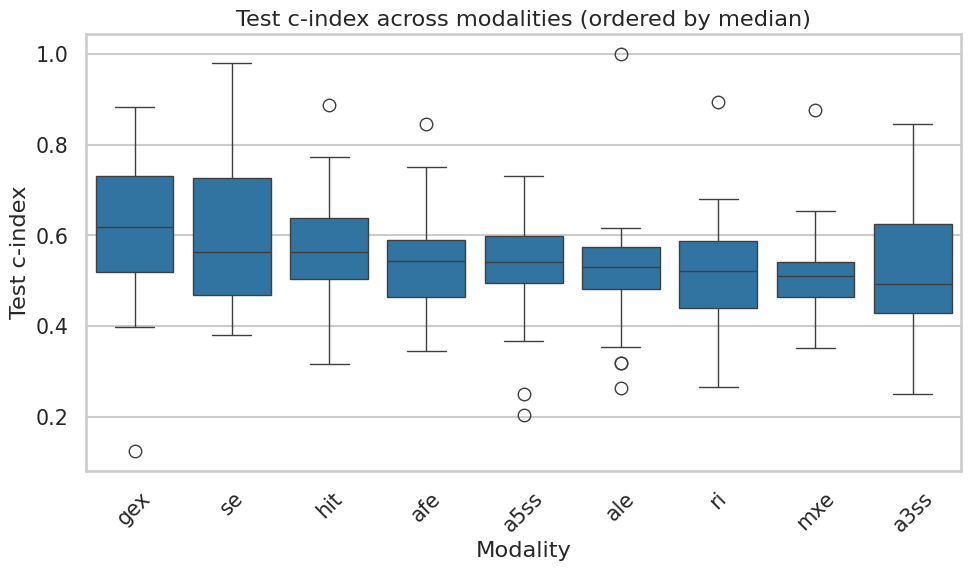

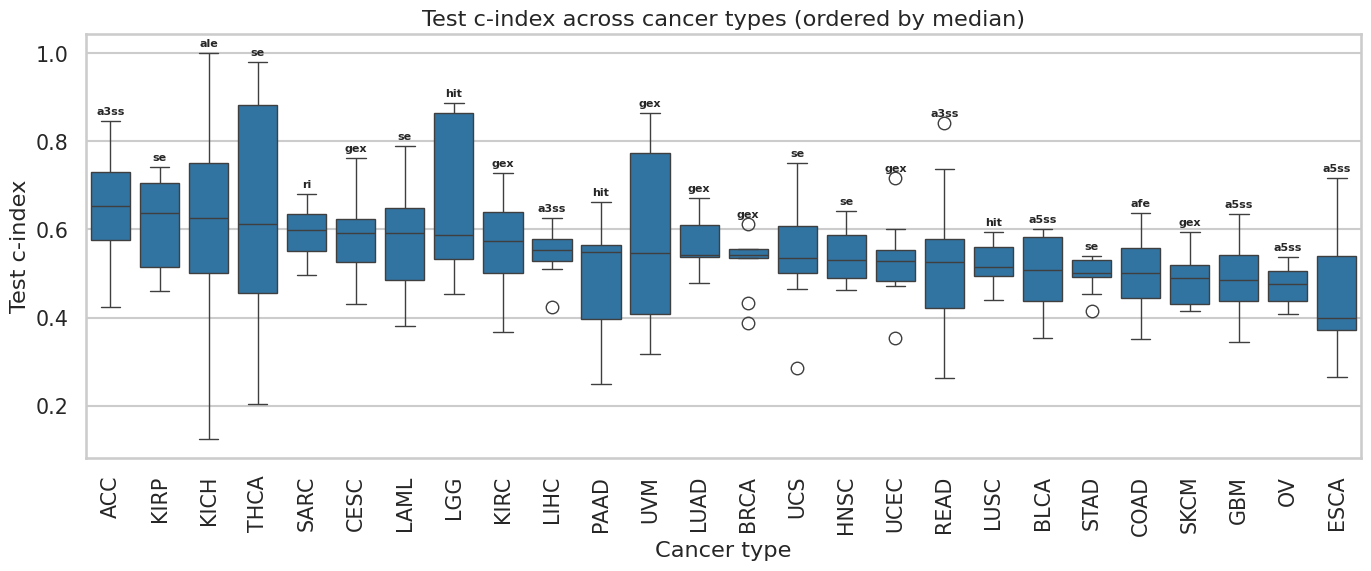

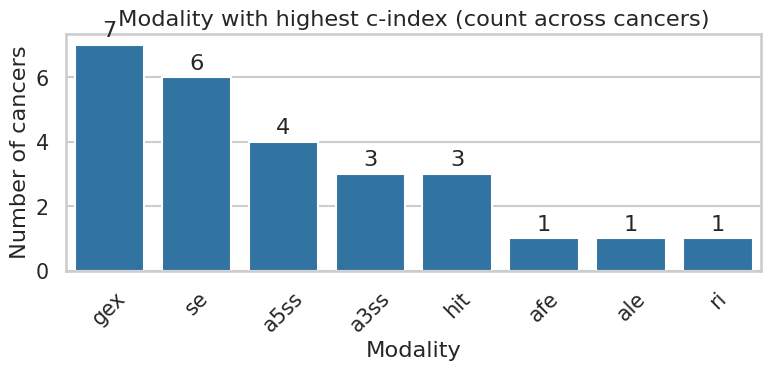

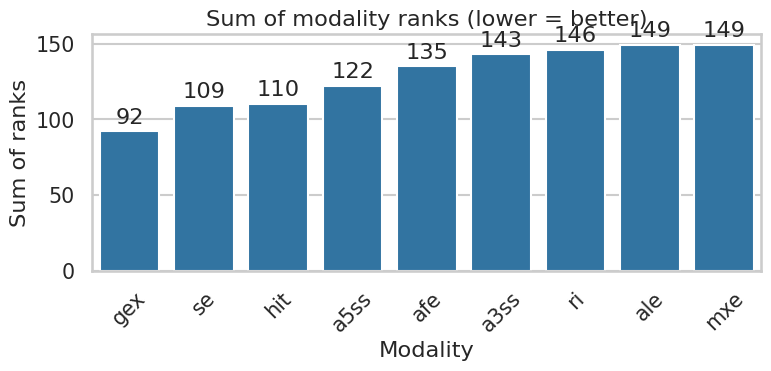

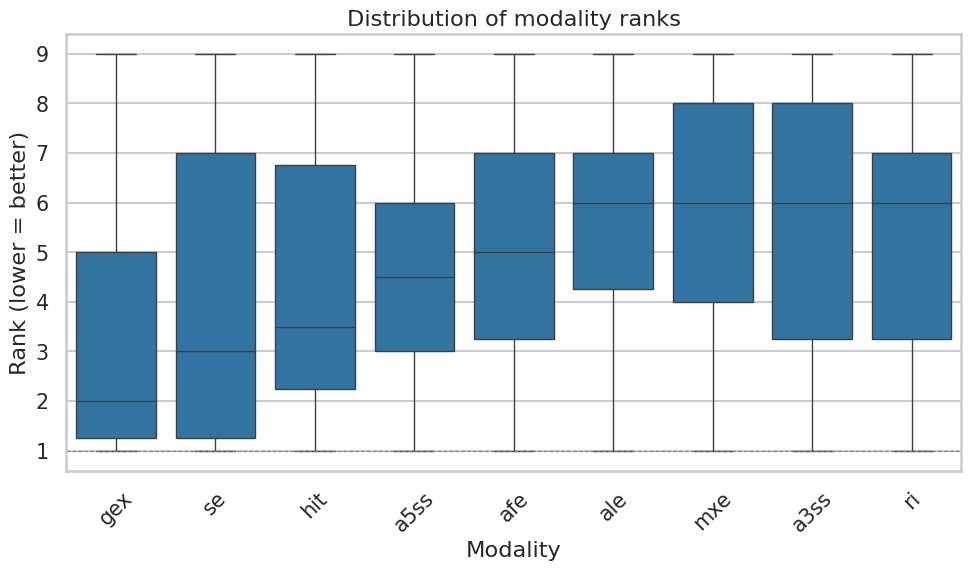

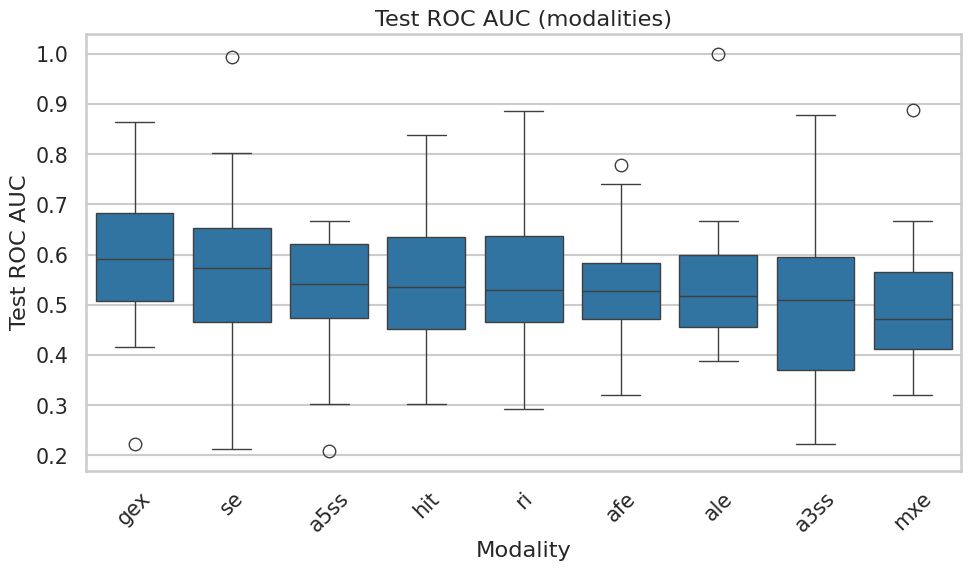

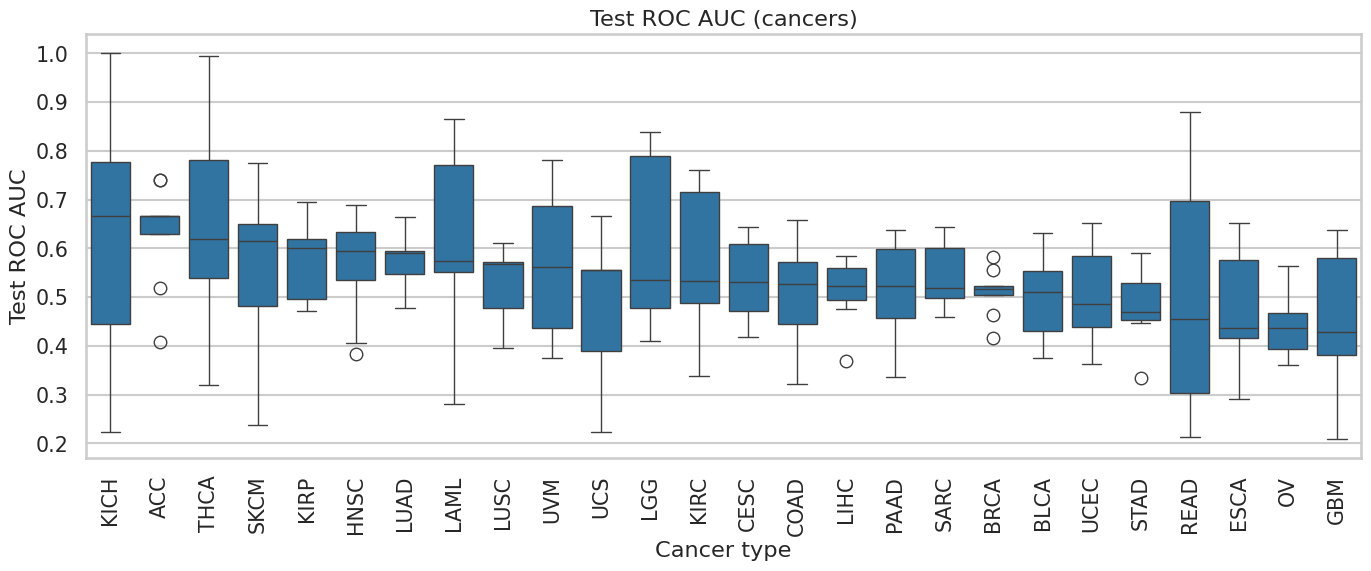

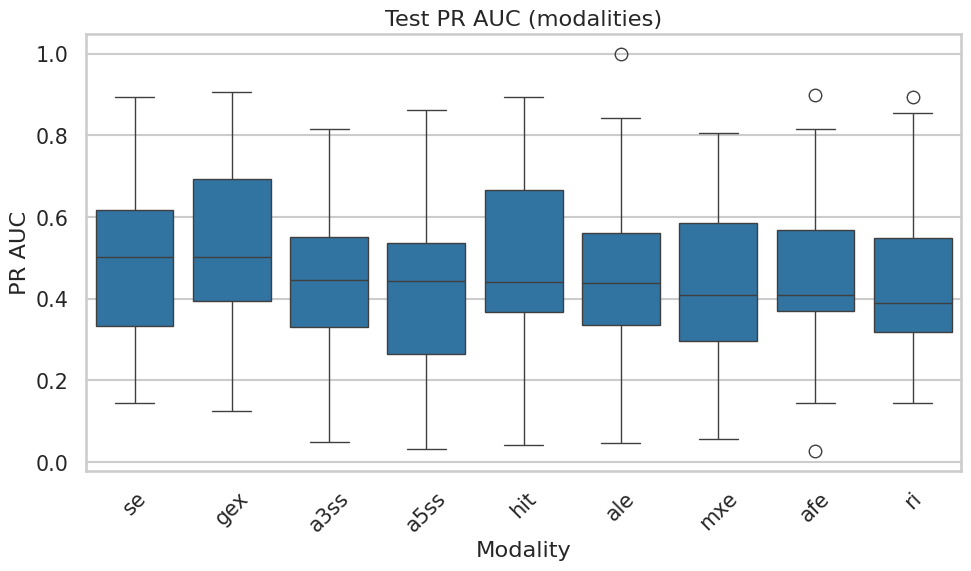

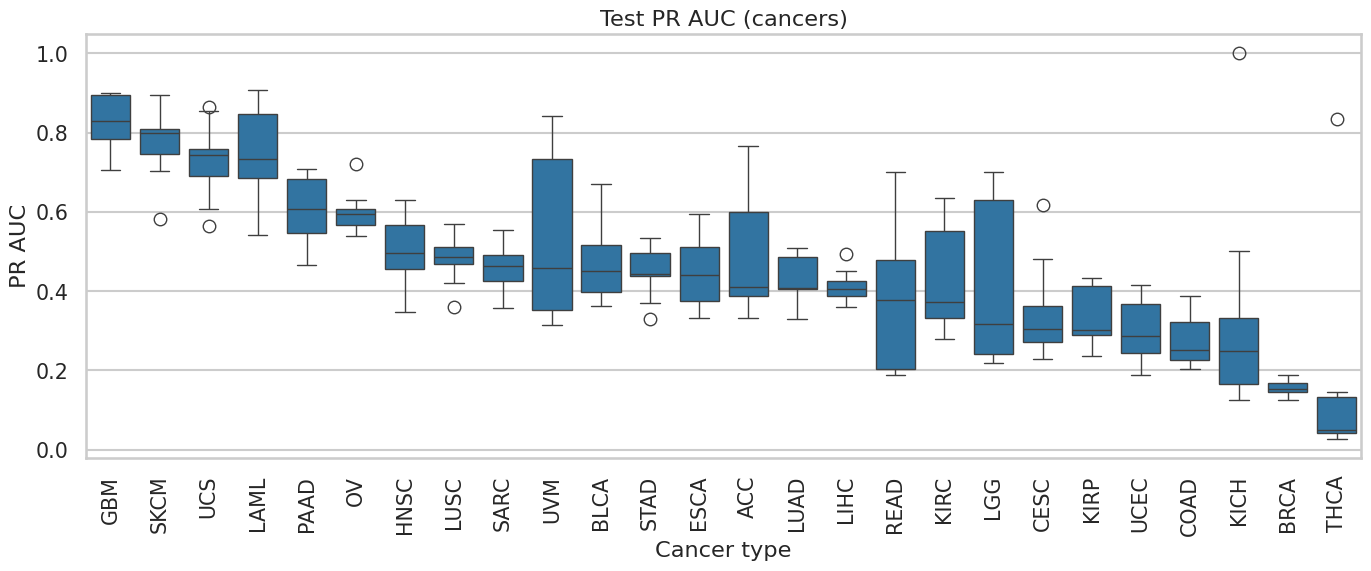

In [12]:
_set_style()

plot_by_modality(df, plot_dir)
plot_by_cancer(df, plot_dir)
plot_winner_counts(df, plot_dir)
plot_rank_summaries(df, plot_dir)

plot_metric_by_modality(
    df, "test_roc_auc",
    "Test ROC AUC (modalities)", "Test ROC AUC",
    "modality_test_roc_auc", plot_dir
)

plot_metric_by_cancer(
    df, "test_roc_auc",
    "Test ROC AUC (cancers)", "Test ROC AUC",
    "cancer_test_roc_auc", plot_dir
)

plot_metric_by_modality(
    df, "test_avg_precision",
    "Test PR AUC (modalities)", "PR AUC",
    "modality_test_pr_auc", plot_dir
)

plot_metric_by_cancer(
    df, "test_avg_precision",
    "Test PR AUC (cancers)", "PR AUC",
    "cancer_test_pr_auc", plot_dir
)

In [ ]:
# Assess overlap of influential genes across modalities
SHAP_ROOT = Path("/projectnb/evolution/zwakefield/tcga/cancer_learning/single_input/model_outputs_12_1_mad10000/shap")
TOP_N_EVENTS = 100

gene_sets = _collect_top_gene_sets(SHAP_ROOT, top_n=TOP_N_EVENTS)
overlap_df = compute_gene_overlaps(gene_sets)
overlap_df.head()

overlap_summary = summarize_gene_overlaps(overlap_df)
overlap_summary

# Visualize per-cancer overlaps and overall summary
plot_cancer_overlap_heatmaps(overlap_df, plot_dir)
plot_overlap_summary(overlap_df, plot_dir)
